In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


# # Define the directory containing the images
# #test_image = "BPS-Microscopy/DAPI_MASK_images"
image_dir = "BPS-Microscopy/train"

# Load the metadata from the Excel file
# metadata_path = 'BPS-Microscopy/DAPI_MASK_images/meta_DAPI_MASK.csv'
metadata_path = 'BPS-Microscopy/train/meta.csv'
metadata = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
# print(metadata.head())

# Add the full path to the filenames in the metadata
metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(image_dir, x))

# Filter only tif
metadata = metadata[metadata['filename'].str.endswith('.tif')]

# Display the first few rows of the updated metadata
# metadata.head()


# Load the list of outlier file paths
outliers_file = "outliers_list.txt"  # Path to the saved outliers list
with open(outliers_file, "r") as f:
    outlier_filepaths = set(line.strip() for line in f)

print(f"Number of outliers to remove: {len(outlier_filepaths)}")

# Remove outliers from the metadata
filtered_metadata = metadata[~metadata['filepath'].isin(outlier_filepaths)]

# Print results
print(f"Original metadata size: {len(metadata)}")
print(f"Filtered metadata size: {len(filtered_metadata)}")

metadata = filtered_metadata

2024-11-24 15:13:38.699765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732490018.719670 1697596 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732490018.726170 1697596 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 15:13:38.749599: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of outliers to remove: 27
Original metadata size: 77177
Filtered metadata size: 77150


In [2]:
from phasepack.phasecong import phasecong
from skimage.measure import shannon_entropy
from skimage.filters import sobel, laplace
from skimage.feature import graycomatrix, graycoprops
from skimage import io
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pickle

def extract_features(image, config):
    """
    Dynamically extracts features based on the configuration.
    Features:
    - Mean Phase Congruency (MPC)
    - Entropy of Phase Congruency (EPC)
    - Entropy of the Image (EDIS)
    - Mean Gradient Magnitude of the Image (MGDIS)
    - Texture Features (GLCM Contrast, Homogeneity)
    - Edge Sharpness (Variance of Laplacian)

    Parameters:
    - image: np.array, input grayscale image
    - config: dict, configuration for which features to extract

    Returns:
    - features: list of feature values
    """
    features = []

    # Compute Phase Congruency features if enabled
    if config.get("include_mpc", True):
        pc_image, *_ = phasecong(image)
        mpc = np.mean(pc_image)
        epc = shannon_entropy(pc_image)
        features.extend([mpc, epc])

    # Compute Image Entropy if enabled
    if config.get("include_edis", True):
        edis = shannon_entropy(image)
        features.append(edis)

    # Compute Mean Gradient Magnitude if enabled
    if config.get("include_mgdis", True):
        gradient_image = sobel(image)
        mgdis = np.mean(gradient_image)
        features.append(mgdis)

    # Compute Texture Features (GLCM) if enabled
    if config.get("include_texture", True):
        glcm = graycomatrix(image.astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        features.extend([contrast, homogeneity])

    # Compute Edge Sharpness (Variance of Laplacian) if enabled
    if config.get("include_sharpness", True):
        laplacian_var = np.var(laplace(image))
        features.append(laplacian_var)

    return features


def prepare_feature_dataset(metadata, config):
    """
    Extract features and labels for a given dataset dynamically based on config.
    """
    features = []
    labels = []
    for _, row in metadata.iterrows():
        image_path = row['filepath']  # Replace with the correct column name for image paths
        try:
            # Load the image
            image = io.imread(image_path, as_gray=True)

            # # Clip pixel values between 400 and 4000
            # image = np.clip(image, 400, 4000)

            # Extract features dynamically
            feature = extract_features(image, config)
            features.append(feature)

            # Append the label
            labels.append(row['dose_Gy'])  # Replace 'dose' with your target column name
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    return np.array(features), np.array(labels)


def load_or_prepare_features(metadata, hr_post_exposure, particle_type, config):
    filtered_metadata = metadata[
        (metadata['hr_post_exposure'] == hr_post_exposure) &
        (metadata['particle_type'] == particle_type)
    ]
    processed_dir = "processed_features"

    # Define filenames dynamically based on filtering criteria
    train_path = os.path.join(processed_dir, f"train_hr{hr_post_exposure}_particle{particle_type}.pkl")
    val_path = os.path.join(processed_dir, f"val_hr{hr_post_exposure}_particle{particle_type}.pkl")
    test_path = os.path.join(processed_dir, f"test_hr{hr_post_exposure}_particle{particle_type}.pkl")

    if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
        print("Loading processed datasets and metadata...")
        with open(train_path, "rb") as f:
            X_train, y_train, train_metadata = pickle.load(f)
        with open(val_path, "rb") as f:
            X_val, y_val, val_metadata = pickle.load(f)
        with open(test_path, "rb") as f:
            X_test, y_test, test_metadata = pickle.load(f)
        print(f"Feature shape (X_train): {X_train.shape}")
        print(f"Feature shape (X_val): {X_val.shape}")
        print(f"Feature shape (X_test): {X_test.shape}")
    else:
        print("Processed datasets not found. Calculating features...")

        # Shuffle and split metadata
        shuffled_metadata = filtered_metadata.sample(frac=1, random_state=42).reset_index(drop=True)
        train_size = int(len(shuffled_metadata) * 0.7)
        val_size = int(len(shuffled_metadata) * 0.2)

        train_metadata = shuffled_metadata[:train_size]
        val_metadata = shuffled_metadata[train_size:train_size + val_size]
        test_metadata = shuffled_metadata[train_size + val_size:]

        # Extract features and labels dynamically
        X_train, y_train = prepare_feature_dataset(train_metadata, config)
        X_val, y_val = prepare_feature_dataset(val_metadata, config)
        X_test, y_test = prepare_feature_dataset(test_metadata, config)

        # Normalize features
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        # Save datasets with metadata
        os.makedirs(processed_dir, exist_ok=True)
        with open(train_path, "wb") as f:
            pickle.dump((X_train, y_train, train_metadata), f)
        with open(val_path, "wb") as f:
            pickle.dump((X_val, y_val, val_metadata), f)
        with open(test_path, "wb") as f:
            pickle.dump((X_test, y_test, test_metadata), f)


        print(f"Feature shape (X_train): {X_train.shape}")
        print(f"Feature shape (X_val): {X_val.shape}")
        print(f"Feature shape (X_test): {X_test.shape}")



    return X_train, y_train, X_val, y_val, X_test, y_test, train_metadata, val_metadata, test_metadata


# Define filtering criteria and feature configuration
hr_post_exposure = 4
particle_type = 'X-ray'

feature_config = {
    "include_mpc": True,
    "include_edis": True,
    "include_mgdis": True,
    "include_texture": True,
    "include_sharpness": True,  # Example of excluding sharpness
}

# Pass criteria and config explicitly to the function
X_train, y_train, X_val, y_val, X_test, y_test, train_metadata, val_metadata, test_metadata = load_or_prepare_features(
    metadata, hr_post_exposure, particle_type, feature_config
)

print(f"Filtering Criteria - hr_post_exposure: {hr_post_exposure}, particle_type: {particle_type}")
print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Loading processed datasets and metadata...
Feature shape (X_train): (9766, 7)
Feature shape (X_val): (2790, 7)
Feature shape (X_test): (1396, 7)
Filtering Criteria - hr_post_exposure: 4, particle_type: X-ray
Train size: 9766, Validation size: 2790, Test size: 1396


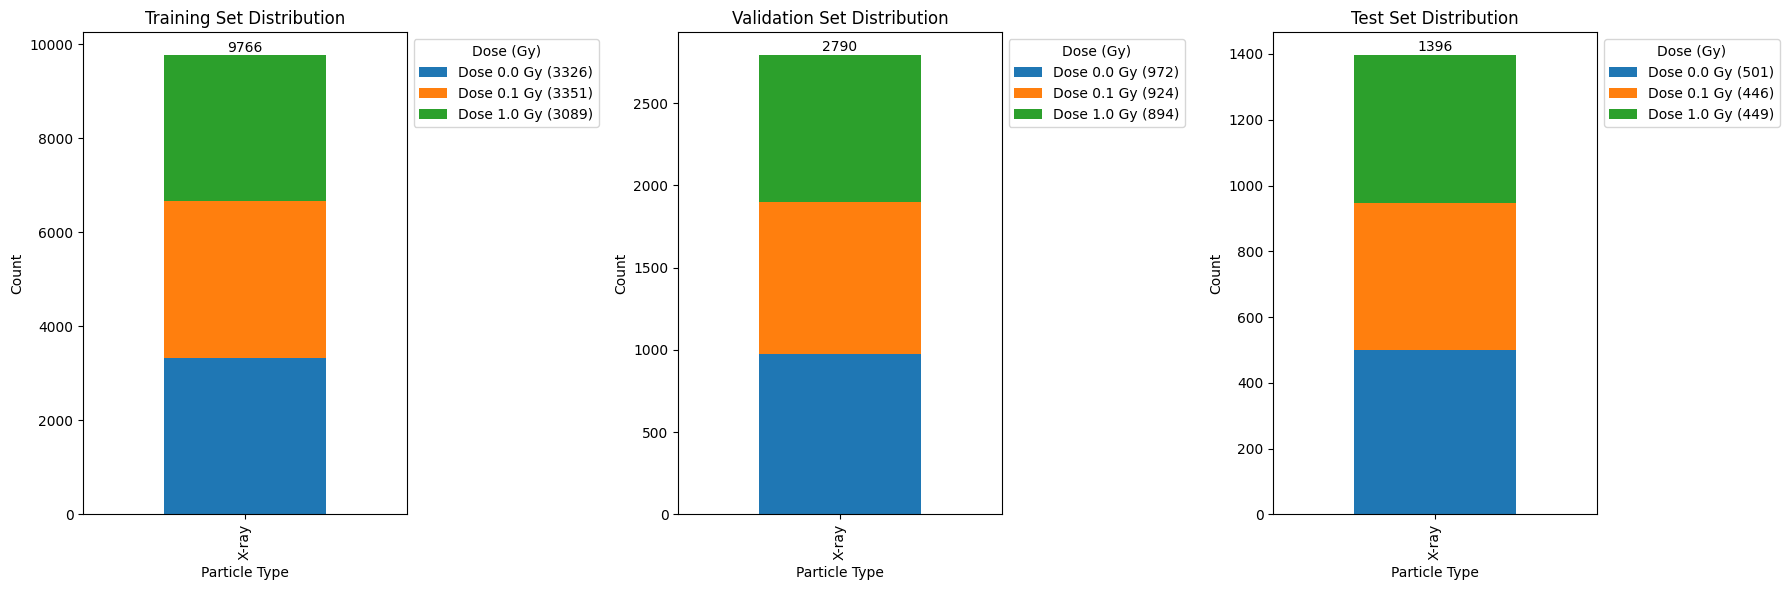

In [3]:
# Check set split

# Function to add total count annotations for each group
def annotate_group_totals(ax, data):
    for i, patch in enumerate(ax.patches):
        if i % len(data.columns) == 0:  # Add annotation only for the first bar of each group
            x = patch.get_x() + patch.get_width() / 2
            total = data.iloc[i // len(data.columns)].sum()
            ax.annotate(f'{int(total)}', (x, total + 5), ha='center', va='bottom', fontsize=10, color='black')

# Function to create legend labels with counts
def create_legend_labels(data):
    labels = []
    for dose in data.columns:
        count = data[dose].sum()
        labels.append(f"Dose {dose} Gy ({int(count)})")
    return labels

# Plot all sets: training, validation, and test
plt.figure(figsize=(18, 6))

# Training set plot
plt.subplot(1, 3, 1)
train_counts = train_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
train_ax = train_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(train_ax, train_counts)
plt.title('Training Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for training set
train_labels = create_legend_labels(train_counts)
plt.legend(train_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Validation set plot
plt.subplot(1, 3, 2)
val_counts = val_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
val_ax = val_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(val_ax, val_counts)
plt.title('Validation Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for validation set
val_labels = create_legend_labels(val_counts)
plt.legend(val_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Test set plot
plt.subplot(1, 3, 3)
test_counts = test_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
test_ax = test_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(test_ax, test_counts)
plt.title('Test Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for test set
test_labels = create_legend_labels(test_counts)
plt.legend(test_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


In [4]:
# Import required libraries
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Sweep Configuration for feature selection, activation functions, and loss functions
sweep_config = {
    'method': 'grid',  # Options: 'grid', 'random', 'bayes'
    'metric': {
        'name': 'val_mae',  # Metric to optimize
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.005]
        },
        'batch_size': {
            'values': [16, 32]
        },
        'epochs': {
            'values': [15, 20]
        },
        'activation_function': {
            'values': ['tanh']  # Activation functions to sweep
        },
        'loss_function': {
            'values': ['mean_absolute_error']  # Loss functions to sweep
        },
        # Feature toggles
        'include_mpc': {'values': [True, False]},
        'include_edis': {'values': [False]},
        'include_mgdis': {'values': [True, False]},
        'include_texture': {'values': [True, False]},
        'include_sharpness': {'values': [True, False]},
    },
    'tags': ["xray_4hr", "grnn_like", "400clip", "nooutliers", "feature_sweep"]
}

# Define GRNN-like network using Keras
def grnn(input_dim, learning_rate, activation_function, loss_function):
    """
    Build a GRNN-like network using Keras.

    Parameters:
    - input_dim: Number of input features
    - learning_rate: Learning rate for the optimizer
    - activation_function: Activation function for the layers
    - loss_function: Loss function to use for training

    Returns:
    - Compiled Keras model
    """
    inputs = layers.Input(shape=(input_dim,))
    pattern_layer = layers.Dense(64, activation=activation_function)(inputs)
    summation_layer = layers.Dense(32, activation=activation_function)(pattern_layer)
    outputs = layers.Dense(1, activation='linear')(summation_layer)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_function,
        metrics=['mae']
    )
    return model

def calculate_input_dim(config):
    """
    Dynamically calculate the number of input features based on the config.
    """
    feature_count = 0
    if config.get('include_mpc', True):  # Use dictionary key access
        feature_count += 2  # MPC and EPC
    if config.get('include_edis', True):
        feature_count += 1  # EDIS
    if config.get('include_mgdis', True):
        feature_count += 1  # MGDIS
    if config.get('include_texture', True):
        feature_count += 2  # Texture: Contrast, Homogeneity
    if config.get('include_sharpness', True):
        feature_count += 1  # Sharpness (Laplacian Variance)
    return feature_count


def subset_features(X, config):
    """
    Subset the feature array dynamically based on the active config.
    """
    selected_features = []
    feature_index = 0

    # Include MPC (2 features: MPC and EPC)
    if config.get('include_mpc', True):
        selected_features.extend([feature_index, feature_index + 1])
        feature_index += 2

    # Include EDIS (1 feature)
    if config.get('include_edis', True):
        selected_features.append(feature_index)
        feature_index += 1

    # Include MGDIS (1 feature)
    if config.get('include_mgdis', True):
        selected_features.append(feature_index)
        feature_index += 1

    # Include Texture (2 features: Contrast and Homogeneity)
    if config.get('include_texture', True):
        selected_features.extend([feature_index, feature_index + 1])
        feature_index += 2

    # Include Sharpness (1 feature)
    if config.get('include_sharpness', True):
        selected_features.append(feature_index)
        feature_index += 1

    # Subset the features
    return X[:, selected_features]



def train():
    # Initialize wandb for this sweep run
    with wandb.init() as run:
        config = run.config

        # Log active feature configuration
        print(f"Active Feature Config: {config}")

        # Dynamically subset the pre-calculated feature arrays
        X_train_subset = subset_features(X_train, config)
        X_val_subset = subset_features(X_val, config)
        X_test_subset = subset_features(X_test, config)

        # Log the shapes after subsetting
        print(f"Subset X_train shape: {X_train_subset.shape}")
        print(f"Subset X_val shape: {X_val_subset.shape}")
        print(f"Subset X_test shape: {X_test_subset.shape}")

        # Calculate dynamic input_dim
        input_dim = X_train_subset.shape[1]
        print(f"Calculated input_dim: {input_dim}")

        # Validate that the feature array dimensions match the expected input_dim
        assert X_train_subset.shape[1] == input_dim, f"Mismatch: X_train has {X_train.shape[1]} features, expected {input_dim}"
        assert X_val_subset.shape[1] == input_dim, f"Mismatch: X_val has {X_val.shape[1]} features, expected {input_dim}"
        assert X_test_subset.shape[1] == input_dim, f"Mismatch: X_test has {X_test.shape[1]} features, expected {input_dim}"

        # Build and compile the model dynamically
        model = grnn(
            input_dim=input_dim,
            learning_rate=config.learning_rate,
            activation_function=config.activation_function,
            loss_function=config.loss_function
        )

        # Train the model with subsetted arrays
        history = model.fit(
            X_train_subset, y_train,
            validation_data=(X_val_subset, y_val),
            epochs=config.epochs,
            batch_size=config.batch_size,
            verbose=2,
            callbacks=[WandbMetricsLogger(log_freq="epoch")]
        )

        # Log training and validation metrics for each epoch
        for epoch in range(config.epochs):
            wandb.log({
                "epoch": epoch,
                "train_loss": history.history['loss'][epoch],
                "val_loss": history.history['val_loss'][epoch],
                "val_mae": history.history['val_mae'][epoch],
                "train_mae": history.history['mae'][epoch]
            })

        # Evaluate the model with subsetted test array
        test_loss, test_mae = model.evaluate(X_test_subset, y_test, verbose=0)
        wandb.log({"Test Loss": test_loss, "Test MAE": test_mae})

        # Predict using the model
        predicted_doses = model.predict(X_test_subset).flatten()

        # Log additional metrics
        r2 = r2_score(y_test, predicted_doses)
        absolute_errors = np.abs(y_test - predicted_doses)
        wandb.log({
            "R²": r2,
            "Mean Absolute Error (Test)": np.mean(absolute_errors),
            "Max Absolute Error (Test)": np.max(absolute_errors)
        })



# Initialize the sweep and run the agent
sweep_id = wandb.sweep(sweep_config, project="dose-prediction")
wandb.agent(sweep_id, train)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('tags' was unexpected)


Create sweep with ID: ijck5aqp
Sweep URL: https://wandb.ai/walt_/dose-prediction/sweeps/ijck5aqp


wandb: Agent Starting Run: n4k7daac with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error
wandb: Currently logged in as: walt_. Use `wandb login --relogin` to force relogin


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 6)
Subset X_val shape: (2790, 6)
Subset X_test shape: (1396, 6)
Calculated input_dim: 6


I0000 00:00:1732490024.099095 1697708 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:33:00.0, compute capability: 8.6


Epoch 1/15


I0000 00:00:1732490025.968909 1697781 service.cc:148] XLA service 0x7f1708003e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732490025.968997 1697781 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-24 15:13:45.987449: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732490026.051521 1697781 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1732490026.738442 1697781 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


611/611 - 4s - 6ms/step - loss: 0.2901 - mae: 0.2901 - val_loss: 0.2680 - val_mae: 0.2680
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2427 - mae: 0.2427 - val_loss: 0.2281 - val_mae: 0.2281
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2140 - mae: 0.2140 - val_loss: 0.2002 - val_mae: 0.2002
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.1985 - mae: 0.1985 - val_loss: 0.1889 - val_mae: 0.1889
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.1953 - mae: 0.1953 - val_loss: 0.2049 - val_mae: 0.2049
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.1929 - mae: 0.1929 - val_loss: 0.1858 - val_mae: 0.1858
Epoch 7/15
611/611 - 1s - 2ms/step - loss: 0.1868 - mae: 0.1868 - val_loss: 0.1870 - val_mae: 0.1870
Epoch 8/15
611/611 - 1s - 2ms/step - loss: 0.1844 - mae: 0.1844 - val_loss: 0.1846 - val_mae: 0.1846
Epoch 9/15
611/611 - 1s - 2ms/step - loss: 0.1863 - mae: 0.1863 - val_loss: 0.1823 - val_mae: 0.1823
Epoch 10/15
611/611 - 1s - 2ms/step - loss: 0.1837 - mae: 0.1837 - val_loss: 0.1914 - val_mae: 0.1914


Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch/mae,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▃▂▃▂▂▁▁▂▂▁▂▁▁


wandb: Agent Starting Run: o3nh1oma with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.2891 - mae: 0.2891 - val_loss: 0.2836 - val_mae: 0.2836
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2723 - mae: 0.2723 - val_loss: 0.2504 - val_mae: 0.2504
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2276 - mae: 0.2276 - val_loss: 0.2093 - val_mae: 0.2093
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2075 - mae: 0.2075 - val_loss: 0.2157 - val_mae: 0.2157
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.2034 - mae: 0.2034 - val_loss: 0.1971 - val_mae: 0.1971
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.1973 - mae: 0.1973 - val_loss: 0.2005 - val_mae: 0.2005
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▆▃▃▂▂▂▁▁▂▁▃▁▂▁


wandb: Agent Starting Run: bkc0kye3 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 5)
Subset X_val shape: (2790, 5)
Subset X_test shape: (1396, 5)
Calculated input_dim: 5
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.2910 - mae: 0.2910 - val_loss: 0.2759 - val_mae: 0.2759
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2731 - mae: 0.2731 - val_loss: 0.2591 - val_mae: 0.2591
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2616 - mae: 0.2616 - val_loss: 0.2282 - val_mae: 0.2282
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2118 - mae: 0.2118 - val_loss: 0.2035 - val_mae: 0.2035
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.1994 - mae: 0.1994 - val_loss: 0.1923 - val_mae: 0.1923
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.1930 - mae: 0.1930 - val_loss: 0.1910 - val_mae: 0.1910
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▃▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▇▆▃▂▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▇▅▃▂▂▂▂▃▃▁▁▁▁▁


wandb: Agent Starting Run: wpfl9185 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.3034 - mae: 0.3034 - val_loss: 0.2903 - val_mae: 0.2903
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2895 - mae: 0.2895 - val_loss: 0.2542 - val_mae: 0.2542
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2504 - mae: 0.2504 - val_loss: 0.2448 - val_mae: 0.2448
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2426 - mae: 0.2426 - val_loss: 0.2331 - val_mae: 0.2331
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.2372 - mae: 0.2372 - val_loss: 0.2289 - val_mae: 0.2289
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.2343 - mae: 0.2343 - val_loss: 0.2303 - val_mae: 0.2303
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch/mae,█▇▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_loss,█▄▃▂▁▁▁▁▂▁▃▂▁▁▁


wandb: Agent Starting Run: kecley05 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.2963 - mae: 0.2963 - val_loss: 0.2903 - val_mae: 0.2903
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2552 - mae: 0.2552 - val_loss: 0.2206 - val_mae: 0.2206
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2178 - mae: 0.2178 - val_loss: 0.2081 - val_mae: 0.2081
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2090 - mae: 0.2090 - val_loss: 0.2122 - val_mae: 0.2122
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.2014 - mae: 0.2014 - val_loss: 0.2063 - val_mae: 0.2063
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.1959 - mae: 0.1959 - val_loss: 0.2014 - val_mae: 0.2014
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▃▂▃▂▂▁▁▁▁▁▂▁▁▁


wandb: Agent Starting Run: zykelgto with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.3002 - mae: 0.3002 - val_loss: 0.3008 - val_mae: 0.3008
Epoch 2/15
611/611 - 2s - 3ms/step - loss: 0.2837 - mae: 0.2837 - val_loss: 0.2544 - val_mae: 0.2544
Epoch 3/15
611/611 - 2s - 3ms/step - loss: 0.2527 - mae: 0.2527 - val_loss: 0.2427 - val_mae: 0.2427
Epoch 4/15
611/611 - 2s - 3ms/step - loss: 0.2445 - mae: 0.2445 - val_loss: 0.2387 - val_mae: 0.2387
Epoch 5/15
611/611 - 2s - 3ms/step - loss: 0.2416 - mae: 0.2416 - val_loss: 0.2378 - val_mae: 0.2378
Epoch 6/15
611/611 - 2s - 3ms/step - loss: 0.2389 - mae: 0.2389 - val_loss: 0.2321 - val_mae: 0.2321
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch/mae,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▄▂▂▂▁▂▁▂▂▂▁▁▁▁


wandb: Agent Starting Run: mablcl01 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/15
611/611 - 3s - 4ms/step - loss: 0.3046 - mae: 0.3046 - val_loss: 0.3199 - val_mae: 0.3199
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2946 - mae: 0.2946 - val_loss: 0.2940 - val_mae: 0.2940
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2946 - mae: 0.2946 - val_loss: 0.2919 - val_mae: 0.2919
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2839 - mae: 0.2839 - val_loss: 0.2480 - val_mae: 0.2480
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.2437 - mae: 0.2437 - val_loss: 0.2355 - val_mae: 0.2355
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.2352 - mae: 0.2352 - val_loss: 0.2299 - val_mae: 0.2299
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▂▂▂▂▂▁▂▁▁▁▁
epoch/mae,█▇▇▆▂▂▂▂▂▁▂▁▁▁▁
epoch/val_loss,█▆▆▃▂▂▂▁▁▁▂▁▁▁▁


wandb: Agent Starting Run: 037j003l with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 1)
Subset X_val shape: (2790, 1)
Subset X_test shape: (1396, 1)
Calculated input_dim: 1
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.2977 - mae: 0.2977 - val_loss: 0.2937 - val_mae: 0.2937
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2965 - mae: 0.2965 - val_loss: 0.2906 - val_mae: 0.2906
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2958 - mae: 0.2958 - val_loss: 0.2995 - val_mae: 0.2995
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2956 - mae: 0.2956 - val_loss: 0.2925 - val_mae: 0.2925
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.2725 - mae: 0.2725 - val_loss: 0.2550 - val_mae: 0.2550
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.2454 - mae: 0.2454 - val_loss: 0.2399 - val_mae: 0.2399
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,████▅▂▂▁▁▁▁▁▁▁▁
epoch/mae,████▅▂▂▁▁▁▁▁▁▁▁
epoch/val_loss,▇▇█▇▃▂▂▁▁▃▁▁▂▁▃


wandb: Agent Starting Run: negrhnz2 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 5)
Subset X_val shape: (2790, 5)
Subset X_test shape: (1396, 5)
Calculated input_dim: 5
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.2953 - mae: 0.2953 - val_loss: 0.2690 - val_mae: 0.2690
Epoch 2/15
611/611 - 2s - 3ms/step - loss: 0.2485 - mae: 0.2485 - val_loss: 0.2155 - val_mae: 0.2155
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2146 - mae: 0.2146 - val_loss: 0.2341 - val_mae: 0.2341
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2038 - mae: 0.2038 - val_loss: 0.1966 - val_mae: 0.1966
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.1968 - mae: 0.1968 - val_loss: 0.2217 - val_mae: 0.2217
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.1930 - mae: 0.1930 - val_loss: 0.1913 - val_mae: 0.1913
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch/mae,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_loss,█▄▅▂▄▂▄▂▁▄▂▁▁▁▁


wandb: Agent Starting Run: rz3qwp5r with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.3010 - mae: 0.3010 - val_loss: 0.2956 - val_mae: 0.2956
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2839 - mae: 0.2839 - val_loss: 0.2489 - val_mae: 0.2489
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2457 - mae: 0.2457 - val_loss: 0.2405 - val_mae: 0.2405
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2398 - mae: 0.2398 - val_loss: 0.2319 - val_mae: 0.2319
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.2352 - mae: 0.2352 - val_loss: 0.2306 - val_mae: 0.2306
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.2351 - mae: 0.2351 - val_loss: 0.2339 - val_mae: 0.2339
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▆▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▄▃▂▂▂▃▂▂▁▁▁▂▁▁


wandb: Agent Starting Run: ygd6q2nv with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/15
611/611 - 3s - 4ms/step - loss: 0.2896 - mae: 0.2896 - val_loss: 0.2630 - val_mae: 0.2630
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2627 - mae: 0.2627 - val_loss: 0.2343 - val_mae: 0.2343
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2163 - mae: 0.2163 - val_loss: 0.2140 - val_mae: 0.2140
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2057 - mae: 0.2057 - val_loss: 0.2213 - val_mae: 0.2213
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.1991 - mae: 0.1991 - val_loss: 0.1973 - val_mae: 0.1973
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.1934 - mae: 0.1934 - val_loss: 0.1951 - val_mae: 0.1951
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch/mae,█▆▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▃▄▂▂▂▂▁▁▁▁▁▁▂


wandb: Agent Starting Run: qkfg2fcm with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.3003 - mae: 0.3003 - val_loss: 0.2988 - val_mae: 0.2988
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2958 - mae: 0.2958 - val_loss: 0.2881 - val_mae: 0.2881
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2937 - mae: 0.2937 - val_loss: 0.2934 - val_mae: 0.2934
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2627 - mae: 0.2627 - val_loss: 0.2442 - val_mae: 0.2442
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.2436 - mae: 0.2436 - val_loss: 0.2412 - val_mae: 0.2412
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.2400 - mae: 0.2400 - val_loss: 0.2375 - val_mae: 0.2375
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▄▂▂▂▁▂▁▁▁▁▁▁
epoch/mae,██▇▄▂▂▂▁▂▁▁▁▁▁▁
epoch/val_loss,█▇▇▃▂▂▂▂▁▁▁▂▁▁▂


wandb: Agent Starting Run: y6ygk0ac with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.2982 - mae: 0.2982 - val_loss: 0.2773 - val_mae: 0.2773
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2593 - mae: 0.2593 - val_loss: 0.2567 - val_mae: 0.2567
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2426 - mae: 0.2426 - val_loss: 0.2345 - val_mae: 0.2345
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2385 - mae: 0.2385 - val_loss: 0.2325 - val_mae: 0.2325
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.2357 - mae: 0.2357 - val_loss: 0.2341 - val_mae: 0.2341
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.2330 - mae: 0.2330 - val_loss: 0.2470 - val_mae: 0.2470
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▂▂▂▁▂▁▁▁▁▁▁▁▁
epoch/mae,█▄▂▂▂▁▂▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▃▂▃▄▄▃▆▂▂▂▂▁▁


wandb: Agent Starting Run: 9swr6sns with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 1)
Subset X_val shape: (2790, 1)
Subset X_test shape: (1396, 1)
Calculated input_dim: 1
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.2990 - mae: 0.2990 - val_loss: 0.3078 - val_mae: 0.3078
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.2968 - mae: 0.2968 - val_loss: 0.2901 - val_mae: 0.2901
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2963 - mae: 0.2963 - val_loss: 0.2945 - val_mae: 0.2945
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2941 - mae: 0.2941 - val_loss: 0.2935 - val_mae: 0.2935
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.2558 - mae: 0.2558 - val_loss: 0.2436 - val_mae: 0.2436
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.2420 - mae: 0.2420 - val_loss: 0.2390 - val_mae: 0.2390
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,███▇▃▂▂▁▁▁▁▁▁▁▁
epoch/mae,███▇▃▂▂▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▇▇▂▂▁▁▂▂▁▁▂▁▁


wandb: Agent Starting Run: 16ouogvy with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/15
611/611 - 4s - 6ms/step - loss: 0.3002 - mae: 0.3002 - val_loss: 0.2924 - val_mae: 0.2924
Epoch 2/15
611/611 - 2s - 3ms/step - loss: 0.2952 - mae: 0.2952 - val_loss: 0.3043 - val_mae: 0.3043
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.2941 - mae: 0.2941 - val_loss: 0.2865 - val_mae: 0.2865
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.2923 - mae: 0.2923 - val_loss: 0.2833 - val_mae: 0.2833
Epoch 5/15
611/611 - 2s - 3ms/step - loss: 0.2611 - mae: 0.2611 - val_loss: 0.2398 - val_mae: 0.2398
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.2438 - mae: 0.2438 - val_loss: 0.2343 - val_mae: 0.2343
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▄▂▂▁▂▁▁▁▁▁▁
epoch/mae,█▇▇▇▄▂▂▁▂▁▁▁▁▁▁
epoch/val_loss,▇█▆▆▂▂▂▃▂▂▃▃▁▁▁


wandb: Agent Starting Run: 5imgswkw with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 0)
Subset X_val shape: (2790, 0)
Subset X_test shape: (1396, 0)
Calculated input_dim: 0
Epoch 1/15
611/611 - 3s - 5ms/step - loss: 0.3218 - mae: 0.3218 - val_loss: 0.3248 - val_mae: 0.3248
Epoch 2/15
611/611 - 1s - 2ms/step - loss: 0.3199 - mae: 0.3199 - val_loss: 0.3242 - val_mae: 0.3242
Epoch 3/15
611/611 - 1s - 2ms/step - loss: 0.3195 - mae: 0.3195 - val_loss: 0.3233 - val_mae: 0.3233
Epoch 4/15
611/611 - 1s - 2ms/step - loss: 0.3194 - mae: 0.3194 - val_loss: 0.3235 - val_mae: 0.3235
Epoch 5/15
611/611 - 1s - 2ms/step - loss: 0.3192 - mae: 0.3192 - val_loss: 0.3233 - val_mae: 0.3233
Epoch 6/15
611/611 - 1s - 2ms/step - loss: 0.3191 - mae: 0.3191 - val_loss: 0.3234 - val_mae: 0.3234
Epo

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▁▁▁▁▂▁▁▂▁▁▁
epoch/mae,█▃▂▂▁▁▁▁▂▁▁▂▁▁▁
epoch/val_loss,█▅▂▂▁▂▁▂▅▇▃▂▃▆▄


wandb: Agent Starting Run: qzf4rv2w with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 6)
Subset X_val shape: (2790, 6)
Subset X_test shape: (1396, 6)
Calculated input_dim: 6
Epoch 1/20
611/611 - 3s - 4ms/step - loss: 0.2933 - mae: 0.2933 - val_loss: 0.2829 - val_mae: 0.2829
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2768 - mae: 0.2768 - val_loss: 0.2827 - val_mae: 0.2827
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2324 - mae: 0.2324 - val_loss: 0.1996 - val_mae: 0.1996
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.1995 - mae: 0.1995 - val_loss: 0.2271 - val_mae: 0.2271
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.1960 - mae: 0.1960 - val_loss: 0.1923 - val_mae: 0.1923
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.1914 - mae: 0.1914 - val_loss: 0.1839 - val_mae: 0.1839
Epoch 7

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▄▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
epoch/mae,█▇▄▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
epoch/val_loss,██▃▄▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 87t2wxo3 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/20
611/611 - 3s - 5ms/step - loss: 0.2934 - mae: 0.2934 - val_loss: 0.2666 - val_mae: 0.2666
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2625 - mae: 0.2625 - val_loss: 0.2323 - val_mae: 0.2323
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2203 - mae: 0.2203 - val_loss: 0.2110 - val_mae: 0.2110
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2079 - mae: 0.2079 - val_loss: 0.2055 - val_mae: 0.2055
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2010 - mae: 0.2010 - val_loss: 0.2039 - val_mae: 0.2039
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.1986 - mae: 0.1986 - val_loss: 0.2142 - val_mae: 0.2142
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▆▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▃▃▃▃▂▃▂▁▂▁▂▁▁▁▂▁▁▁


wandb: Agent Starting Run: 3tmj5lx9 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 5)
Subset X_val shape: (2790, 5)
Subset X_test shape: (1396, 5)
Calculated input_dim: 5
Epoch 1/20
611/611 - 3s - 4ms/step - loss: 0.2896 - mae: 0.2896 - val_loss: 0.2655 - val_mae: 0.2655
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2735 - mae: 0.2735 - val_loss: 0.2708 - val_mae: 0.2708
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2237 - mae: 0.2237 - val_loss: 0.1984 - val_mae: 0.1984
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.1992 - mae: 0.1992 - val_loss: 0.2047 - val_mae: 0.2047
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.1940 - mae: 0.1940 - val_loss: 0.1891 - val_mae: 0.1891
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.1914 - mae: 0.1914 - val_loss: 0.1902 - val_mae: 0.1902
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,██▃▃▂▂▂▂▂▁▁▁▃▁▂▃▁▃▁▁


wandb: Agent Starting Run: 4imgk0j8 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/20
611/611 - 3s - 5ms/step - loss: 0.3000 - mae: 0.3000 - val_loss: 0.2998 - val_mae: 0.2998
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2950 - mae: 0.2950 - val_loss: 0.2920 - val_mae: 0.2920
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2946 - mae: 0.2946 - val_loss: 0.2873 - val_mae: 0.2873
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2916 - mae: 0.2916 - val_loss: 0.2987 - val_mae: 0.2987
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2814 - mae: 0.2814 - val_loss: 0.2412 - val_mae: 0.2412
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.2426 - mae: 0.2426 - val_loss: 0.2311 - val_mae: 0.2311
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▆▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁
epoch/mae,██▇▇▆▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁
epoch/val_loss,█▇▇█▃▂▂▃▂▂▁▂▁▁▁▂▁▁▁▁


wandb: Agent Starting Run: adgjh3y7 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/20
611/611 - 3s - 5ms/step - loss: 0.2898 - mae: 0.2898 - val_loss: 0.2720 - val_mae: 0.2720
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2708 - mae: 0.2708 - val_loss: 0.2364 - val_mae: 0.2364
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2248 - mae: 0.2248 - val_loss: 0.2345 - val_mae: 0.2345
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2066 - mae: 0.2066 - val_loss: 0.2068 - val_mae: 0.2068
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2000 - mae: 0.2000 - val_loss: 0.2055 - val_mae: 0.2055
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.1979 - mae: 0.1979 - val_loss: 0.1973 - val_mae: 0.1973
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▄▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▄▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▅▃▃▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁


wandb: Agent Starting Run: 536dajis with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/20
611/611 - 3s - 4ms/step - loss: 0.3001 - mae: 0.3001 - val_loss: 0.3012 - val_mae: 0.3012
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2951 - mae: 0.2951 - val_loss: 0.2870 - val_mae: 0.2870
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2936 - mae: 0.2936 - val_loss: 0.2880 - val_mae: 0.2880
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2909 - mae: 0.2909 - val_loss: 0.2658 - val_mae: 0.2658
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2503 - mae: 0.2503 - val_loss: 0.2446 - val_mae: 0.2446
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.2411 - mae: 0.2411 - val_loss: 0.2367 - val_mae: 0.2367
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▇▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▇▅▃▂▃▂▂▁▁▂▁▂▁▂▂▁▂▁


wandb: Agent Starting Run: z1w75bb1 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/20
611/611 - 3s - 5ms/step - loss: 0.3037 - mae: 0.3037 - val_loss: 0.2988 - val_mae: 0.2988
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2933 - mae: 0.2933 - val_loss: 0.2776 - val_mae: 0.2776
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2591 - mae: 0.2591 - val_loss: 0.2468 - val_mae: 0.2468
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2442 - mae: 0.2442 - val_loss: 0.2366 - val_mae: 0.2366
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2394 - mae: 0.2394 - val_loss: 0.2460 - val_mae: 0.2460
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.2366 - mae: 0.2366 - val_loss: 0.2326 - val_mae: 0.2326
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▄▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁
epoch/mae,█▇▄▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁
epoch/val_loss,█▆▃▂▃▂▂▂▂▁▂▂▃▁▁▁▁▁▂▂


wandb: Agent Starting Run: 4g2mxp7k with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 1)
Subset X_val shape: (2790, 1)
Subset X_test shape: (1396, 1)
Calculated input_dim: 1
Epoch 1/20
611/611 - 3s - 5ms/step - loss: 0.2964 - mae: 0.2964 - val_loss: 0.2897 - val_mae: 0.2897
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2972 - mae: 0.2972 - val_loss: 0.2929 - val_mae: 0.2929
Epoch 3/20
611/611 - 2s - 3ms/step - loss: 0.2960 - mae: 0.2960 - val_loss: 0.2903 - val_mae: 0.2903
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2951 - mae: 0.2951 - val_loss: 0.2843 - val_mae: 0.2843
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2522 - mae: 0.2522 - val_loss: 0.2464 - val_mae: 0.2464
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.2427 - mae: 0.2427 - val_loss: 0.2417 - val_mae: 0.2417
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,████▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,████▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,███▇▃▂▂▂▂▃▂▂▁▁▁▂▂▂▁▁


wandb: Agent Starting Run: v89hcy3y with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 5)
Subset X_val shape: (2790, 5)
Subset X_test shape: (1396, 5)
Calculated input_dim: 5
Epoch 1/20
611/611 - 3s - 5ms/step - loss: 0.2885 - mae: 0.2885 - val_loss: 0.2718 - val_mae: 0.2718
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2729 - mae: 0.2729 - val_loss: 0.2580 - val_mae: 0.2580
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2415 - mae: 0.2415 - val_loss: 0.2102 - val_mae: 0.2102
Epoch 4/20
611/611 - 2s - 3ms/step - loss: 0.2102 - mae: 0.2102 - val_loss: 0.2079 - val_mae: 0.2079
Epoch 5/20
611/611 - 2s - 2ms/step - loss: 0.1985 - mae: 0.1985 - val_loss: 0.1961 - val_mae: 0.1961
Epoch 6/20
611/611 - 2s - 3ms/step - loss: 0.1922 - mae: 0.1922 - val_loss: 0.1865 - val_mae: 0.1865
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▃▃▂▂▂▂▂▁▂▂▁▂▁▂▂▂▁▁


wandb: Agent Starting Run: 7ptr5onz with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/20
611/611 - 3s - 5ms/step - loss: 0.3059 - mae: 0.3059 - val_loss: 0.2861 - val_mae: 0.2861
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2955 - mae: 0.2955 - val_loss: 0.2917 - val_mae: 0.2917
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2913 - mae: 0.2913 - val_loss: 0.2742 - val_mae: 0.2742
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2527 - mae: 0.2527 - val_loss: 0.2360 - val_mae: 0.2360
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2405 - mae: 0.2405 - val_loss: 0.2366 - val_mae: 0.2366
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.2382 - mae: 0.2382 - val_loss: 0.2321 - val_mae: 0.2321
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▇▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▇█▆▂▂▂▂▁▂▁▁▂▂▁▂▁▁▁▂▁


wandb: Agent Starting Run: eysy6d7c with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/20
611/611 - 3s - 4ms/step - loss: 0.2932 - mae: 0.2932 - val_loss: 0.2697 - val_mae: 0.2697
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2635 - mae: 0.2635 - val_loss: 0.2240 - val_mae: 0.2240
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2156 - mae: 0.2156 - val_loss: 0.2101 - val_mae: 0.2101
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2052 - mae: 0.2052 - val_loss: 0.2016 - val_mae: 0.2016
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.1987 - mae: 0.1987 - val_loss: 0.2153 - val_mae: 0.2153
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.1947 - mae: 0.1947 - val_loss: 0.2057 - val_mae: 0.2057
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▆▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▄▃▂▃▃▄▂▂▃▃▂▂▁▂▁▂▁▂▁


wandb: Agent Starting Run: 8k2ohbqt with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/20
611/611 - 3s - 4ms/step - loss: 0.3021 - mae: 0.3021 - val_loss: 0.2908 - val_mae: 0.2908
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2810 - mae: 0.2810 - val_loss: 0.2479 - val_mae: 0.2479
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2476 - mae: 0.2476 - val_loss: 0.2479 - val_mae: 0.2479
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2415 - mae: 0.2415 - val_loss: 0.2352 - val_mae: 0.2352
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2381 - mae: 0.2381 - val_loss: 0.2395 - val_mae: 0.2395
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.2358 - mae: 0.2358 - val_loss: 0.2328 - val_mae: 0.2328
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁
epoch/mae,█▆▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁
epoch/val_loss,█▃▃▂▂▂▂▁▁▃▂▂▂▁▂▁▁▁▁▂


wandb: Agent Starting Run: sxhdd768 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/20
611/611 - 3s - 5ms/step - loss: 0.3006 - mae: 0.3006 - val_loss: 0.2922 - val_mae: 0.2922
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2939 - mae: 0.2939 - val_loss: 0.3001 - val_mae: 0.3001
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2946 - mae: 0.2946 - val_loss: 0.2946 - val_mae: 0.2946
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2932 - mae: 0.2932 - val_loss: 0.2890 - val_mae: 0.2890
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2637 - mae: 0.2637 - val_loss: 0.2364 - val_mae: 0.2364
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.2385 - mae: 0.2385 - val_loss: 0.2364 - val_mae: 0.2364
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▄▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁
epoch/mae,█▇▇▇▄▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁
epoch/val_loss,▇██▇▂▂▂▂▃▂▁▁▁▂▂▁▁▁▂▁


wandb: Agent Starting Run: di5mtkyf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 1)
Subset X_val shape: (2790, 1)
Subset X_test shape: (1396, 1)
Calculated input_dim: 1
Epoch 1/20
611/611 - 3s - 5ms/step - loss: 0.3000 - mae: 0.3000 - val_loss: 0.2970 - val_mae: 0.2970
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2954 - mae: 0.2954 - val_loss: 0.2908 - val_mae: 0.2908
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2956 - mae: 0.2956 - val_loss: 0.2905 - val_mae: 0.2905
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2951 - mae: 0.2951 - val_loss: 0.2977 - val_mae: 0.2977
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2821 - mae: 0.2821 - val_loss: 0.2594 - val_mae: 0.2594
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.2468 - mae: 0.2468 - val_loss: 0.2431 - val_mae: 0.2431
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,███▇▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,███▇▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▇█▄▂▂▂▂▁▁▁▄▁▁▁▁▁▂▂


wandb: Agent Starting Run: 76xoamtp with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/20
611/611 - 3s - 4ms/step - loss: 0.3019 - mae: 0.3019 - val_loss: 0.2964 - val_mae: 0.2964
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2923 - mae: 0.2923 - val_loss: 0.2759 - val_mae: 0.2759
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2549 - mae: 0.2549 - val_loss: 0.2392 - val_mae: 0.2392
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2425 - mae: 0.2425 - val_loss: 0.2342 - val_mae: 0.2342
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2384 - mae: 0.2384 - val_loss: 0.2360 - val_mae: 0.2360
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.2355 - mae: 0.2355 - val_loss: 0.2380 - val_mae: 0.2380
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▄▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁
epoch/mae,█▇▄▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁
epoch/val_loss,█▆▂▂▂▂▃▁▂▁▄▂▂▁▁▁▂▂▁▁


wandb: Agent Starting Run: ia6aeyge with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 16, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 0)
Subset X_val shape: (2790, 0)
Subset X_test shape: (1396, 0)
Calculated input_dim: 0
Epoch 1/20
611/611 - 3s - 4ms/step - loss: 0.3211 - mae: 0.3211 - val_loss: 0.3247 - val_mae: 0.3247
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.3203 - mae: 0.3203 - val_loss: 0.3237 - val_mae: 0.3237
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.3195 - mae: 0.3195 - val_loss: 0.3238 - val_mae: 0.3238
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.3192 - mae: 0.3192 - val_loss: 0.3237 - val_mae: 0.3237
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.3193 - mae: 0.3193 - val_loss: 0.3239 - val_mae: 0.3239
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.3192 - mae: 0.3192 - val_loss: 0.3247 - val_mae: 0.3247
Epo

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▂▁▂▁▂▂▂▂▁▁▁▂▂▁▂▅▁▁
epoch/mae,█▅▂▁▂▁▂▂▂▂▁▁▁▂▂▁▂▅▁▁
epoch/val_loss,▂▁▁▁▁▂▁▁▁▁▂▂▂▂▂▁█▁▂▁


wandb: Agent Starting Run: 6x00vk67 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 6)
Subset X_val shape: (2790, 6)
Subset X_test shape: (1396, 6)
Calculated input_dim: 6
Epoch 1/15
306/306 - 3s - 11ms/step - loss: 0.2913 - mae: 0.2913 - val_loss: 0.2957 - val_mae: 0.2957
Epoch 2/15
306/306 - 1s - 4ms/step - loss: 0.2646 - mae: 0.2646 - val_loss: 0.2563 - val_mae: 0.2563
Epoch 3/15
306/306 - 1s - 3ms/step - loss: 0.2217 - mae: 0.2217 - val_loss: 0.2191 - val_mae: 0.2191
Epoch 4/15
306/306 - 1s - 3ms/step - loss: 0.2057 - mae: 0.2057 - val_loss: 0.2330 - val_mae: 0.2330
Epoch 5/15
306/306 - 1s - 3ms/step - loss: 0.2020 - mae: 0.2020 - val_loss: 0.1998 - val_mae: 0.1998
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.1940 - mae: 0.1940 - val_loss: 0.2063 - val_mae: 0.2063
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▆▃▄▂▃▂▂▂▂▁▁▁▁▂


wandb: Agent Starting Run: dz8uwe6n with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/15
306/306 - 2s - 8ms/step - loss: 0.2931 - mae: 0.2931 - val_loss: 0.2806 - val_mae: 0.2806
Epoch 2/15
306/306 - 1s - 2ms/step - loss: 0.2631 - mae: 0.2631 - val_loss: 0.2436 - val_mae: 0.2436
Epoch 3/15
306/306 - 1s - 3ms/step - loss: 0.2299 - mae: 0.2299 - val_loss: 0.2572 - val_mae: 0.2572
Epoch 4/15
306/306 - 1s - 3ms/step - loss: 0.2116 - mae: 0.2116 - val_loss: 0.2069 - val_mae: 0.2069
Epoch 5/15
306/306 - 1s - 3ms/step - loss: 0.2060 - mae: 0.2060 - val_loss: 0.2048 - val_mae: 0.2048
Epoch 6/15
306/306 - 1s - 3ms/step - loss: 0.2007 - mae: 0.2007 - val_loss: 0.2139 - val_mae: 0.2139
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▅▆▂▂▃▂▂▂▁▁▁▂▁▁


wandb: Agent Starting Run: wsk4sm2t with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 5)
Subset X_val shape: (2790, 5)
Subset X_test shape: (1396, 5)
Calculated input_dim: 5
Epoch 1/15
306/306 - 2s - 7ms/step - loss: 0.2992 - mae: 0.2992 - val_loss: 0.2764 - val_mae: 0.2764
Epoch 2/15
306/306 - 1s - 2ms/step - loss: 0.2773 - mae: 0.2773 - val_loss: 0.2593 - val_mae: 0.2593
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2502 - mae: 0.2502 - val_loss: 0.2295 - val_mae: 0.2295
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.2198 - mae: 0.2198 - val_loss: 0.2195 - val_mae: 0.2195
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.2073 - mae: 0.2073 - val_loss: 0.2046 - val_mae: 0.2046
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.1994 - mae: 0.1994 - val_loss: 0.2035 - val_mae: 0.2035
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▃▃▂▂▂▂▂▁▁▁▁▁
epoch/mae,█▇▅▃▃▂▂▂▂▂▁▁▁▁▁
epoch/val_loss,█▇▅▄▃▃▂▂▂▁▁▃▁▂▁


wandb: Agent Starting Run: 0jts4mwd with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/15
306/306 - 2s - 8ms/step - loss: 0.3028 - mae: 0.3028 - val_loss: 0.2906 - val_mae: 0.2906
Epoch 2/15
306/306 - 1s - 3ms/step - loss: 0.2930 - mae: 0.2930 - val_loss: 0.2869 - val_mae: 0.2869
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2935 - mae: 0.2935 - val_loss: 0.2865 - val_mae: 0.2865
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.2945 - mae: 0.2945 - val_loss: 0.2948 - val_mae: 0.2948
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.2915 - mae: 0.2915 - val_loss: 0.2962 - val_mae: 0.2962
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.2819 - mae: 0.2819 - val_loss: 0.2544 - val_mae: 0.2544
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▇▆▃▂▂▁▁▁▁▁▁
epoch/mae,█▇▇▇▇▆▃▂▂▁▁▁▁▁▁
epoch/val_loss,▇▇▇██▄▂▃▂▂▁▃▂▂▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l12ofe33 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/15
306/306 - 3s - 9ms/step - loss: 0.2933 - mae: 0.2933 - val_loss: 0.2715 - val_mae: 0.2715
Epoch 2/15
306/306 - 1s - 2ms/step - loss: 0.2738 - mae: 0.2738 - val_loss: 0.2604 - val_mae: 0.2604
Epoch 3/15
306/306 - 1s - 3ms/step - loss: 0.2702 - mae: 0.2702 - val_loss: 0.2669 - val_mae: 0.2669
Epoch 4/15
306/306 - 1s - 3ms/step - loss: 0.2621 - mae: 0.2621 - val_loss: 0.2624 - val_mae: 0.2624
Epoch 5/15
306/306 - 1s - 3ms/step - loss: 0.2554 - mae: 0.2554 - val_loss: 0.2326 - val_mae: 0.2326
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.2196 - mae: 0.2196 - val_loss: 0.2128 - val_mae: 0.2128
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▆▃▂▂▂▂▁▁▁▁▁
epoch/mae,█▇▆▆▆▃▂▂▂▂▁▁▁▁▁
epoch/val_loss,█▇█▇▅▃▃▄▂▂▂▂▁▂▁


wandb: Agent Starting Run: 6kqnl63l with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/15
306/306 - 2s - 8ms/step - loss: 0.3037 - mae: 0.3037 - val_loss: 0.2900 - val_mae: 0.2900
Epoch 2/15
306/306 - 1s - 3ms/step - loss: 0.2940 - mae: 0.2940 - val_loss: 0.2884 - val_mae: 0.2884
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2917 - mae: 0.2917 - val_loss: 0.2940 - val_mae: 0.2940
Epoch 4/15
306/306 - 1s - 3ms/step - loss: 0.2917 - mae: 0.2917 - val_loss: 0.2778 - val_mae: 0.2778
Epoch 5/15
306/306 - 1s - 3ms/step - loss: 0.2571 - mae: 0.2571 - val_loss: 0.2457 - val_mae: 0.2457
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.2433 - mae: 0.2433 - val_loss: 0.2457 - val_mae: 0.2457
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▃▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▇▇▇▃▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▇█▆▃▃▁▁▂▁▁▁▁▁▃


wandb: Agent Starting Run: acqspf3s with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/15
306/306 - 2s - 7ms/step - loss: 0.3035 - mae: 0.3035 - val_loss: 0.2972 - val_mae: 0.2972
Epoch 2/15
306/306 - 1s - 3ms/step - loss: 0.2879 - mae: 0.2879 - val_loss: 0.2721 - val_mae: 0.2721
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2623 - mae: 0.2623 - val_loss: 0.2670 - val_mae: 0.2670
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.2490 - mae: 0.2490 - val_loss: 0.2446 - val_mae: 0.2446
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.2421 - mae: 0.2421 - val_loss: 0.2385 - val_mae: 0.2385
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.2394 - mae: 0.2394 - val_loss: 0.2347 - val_mae: 0.2347
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▆▅▃▂▂▂▂▂▁▁▁▁▂▁


wandb: Agent Starting Run: ddh4dqjm with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 1)
Subset X_val shape: (2790, 1)
Subset X_test shape: (1396, 1)
Calculated input_dim: 1
Epoch 1/15
306/306 - 3s - 8ms/step - loss: 0.2980 - mae: 0.2980 - val_loss: 0.2949 - val_mae: 0.2949
Epoch 2/15
306/306 - 1s - 2ms/step - loss: 0.2950 - mae: 0.2950 - val_loss: 0.2902 - val_mae: 0.2902
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2948 - mae: 0.2948 - val_loss: 0.2957 - val_mae: 0.2957
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.2952 - mae: 0.2952 - val_loss: 0.2939 - val_mae: 0.2939
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.2951 - mae: 0.2951 - val_loss: 0.3068 - val_mae: 0.3068
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.2953 - mae: 0.2953 - val_loss: 0.2924 - val_mae: 0.2924
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,███████▇▂▂▁▁▁▁▁
epoch/mae,███████▇▂▂▁▁▁▁▁
epoch/val_loss,▇▆▇▇█▇▇▄▄▁▁▂▁▁▁


wandb: Agent Starting Run: 39ktx208 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 5)
Subset X_val shape: (2790, 5)
Subset X_test shape: (1396, 5)
Calculated input_dim: 5
Epoch 1/15
306/306 - 3s - 8ms/step - loss: 0.2898 - mae: 0.2898 - val_loss: 0.2736 - val_mae: 0.2736
Epoch 2/15
306/306 - 1s - 3ms/step - loss: 0.2612 - mae: 0.2612 - val_loss: 0.2319 - val_mae: 0.2319
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2229 - mae: 0.2229 - val_loss: 0.2257 - val_mae: 0.2257
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.2094 - mae: 0.2094 - val_loss: 0.2109 - val_mae: 0.2109
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.2041 - mae: 0.2041 - val_loss: 0.2138 - val_mae: 0.2138
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.1984 - mae: 0.1984 - val_loss: 0.2049 - val_mae: 0.2049
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁
epoch/mae,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▄▃▃▃▂▂▁▄▁▁▁▂▂


wandb: Agent Starting Run: 1tg46fwj with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/15
306/306 - 2s - 7ms/step - loss: 0.3072 - mae: 0.3072 - val_loss: 0.2852 - val_mae: 0.2852
Epoch 2/15
306/306 - 1s - 2ms/step - loss: 0.2894 - mae: 0.2894 - val_loss: 0.2757 - val_mae: 0.2757
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2623 - mae: 0.2623 - val_loss: 0.2520 - val_mae: 0.2520
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.2475 - mae: 0.2475 - val_loss: 0.2536 - val_mae: 0.2536
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.2423 - mae: 0.2423 - val_loss: 0.2360 - val_mae: 0.2360
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.2392 - mae: 0.2392 - val_loss: 0.2362 - val_mae: 0.2362
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁
epoch/mae,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▄▄▂▂▂▂▁▁▂▁▁▁▁


wandb: Agent Starting Run: oc1r936d with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/15
306/306 - 2s - 7ms/step - loss: 0.2927 - mae: 0.2927 - val_loss: 0.2797 - val_mae: 0.2797
Epoch 2/15
306/306 - 1s - 2ms/step - loss: 0.2726 - mae: 0.2726 - val_loss: 0.2609 - val_mae: 0.2609
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2658 - mae: 0.2658 - val_loss: 0.2676 - val_mae: 0.2676
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.2647 - mae: 0.2647 - val_loss: 0.2584 - val_mae: 0.2584
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.2613 - mae: 0.2613 - val_loss: 0.2605 - val_mae: 0.2605
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.2605 - mae: 0.2605 - val_loss: 0.2523 - val_mae: 0.2523
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▆▆▄▂▂▂▁▁▁▁▁
epoch/mae,█▇▆▆▆▆▄▂▂▂▁▁▁▁▁
epoch/val_loss,█▆▇▆▆▆▄▂▂▂▂▁▂▁▁


wandb: Agent Starting Run: h3pt8jy6 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/15
306/306 - 2s - 7ms/step - loss: 0.2988 - mae: 0.2988 - val_loss: 0.2886 - val_mae: 0.2886
Epoch 2/15
306/306 - 1s - 2ms/step - loss: 0.2911 - mae: 0.2911 - val_loss: 0.2795 - val_mae: 0.2795
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2641 - mae: 0.2641 - val_loss: 0.2448 - val_mae: 0.2448
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.2458 - mae: 0.2458 - val_loss: 0.2445 - val_mae: 0.2445
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.2416 - mae: 0.2416 - val_loss: 0.2418 - val_mae: 0.2418
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.2367 - mae: 0.2367 - val_loss: 0.2355 - val_mae: 0.2355
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▄▂▂▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▄▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▃▃▃▂▃▂▂▁▂▂▁▂▁


wandb: Agent Starting Run: e5urhbus with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/15
306/306 - 2s - 7ms/step - loss: 0.3031 - mae: 0.3031 - val_loss: 0.2998 - val_mae: 0.2998
Epoch 2/15
306/306 - 1s - 3ms/step - loss: 0.2715 - mae: 0.2715 - val_loss: 0.2504 - val_mae: 0.2504
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2520 - mae: 0.2520 - val_loss: 0.2423 - val_mae: 0.2423
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.2454 - mae: 0.2454 - val_loss: 0.2398 - val_mae: 0.2398
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.2413 - mae: 0.2413 - val_loss: 0.2398 - val_mae: 0.2398
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.2362 - mae: 0.2362 - val_loss: 0.2319 - val_mae: 0.2319
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▃▃▂▂▂▂▂▁▁▂▂▂▁▁


wandb: Agent Starting Run: jbqtzyo3 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 1)
Subset X_val shape: (2790, 1)
Subset X_test shape: (1396, 1)
Calculated input_dim: 1
Epoch 1/15
306/306 - 2s - 7ms/step - loss: 0.2971 - mae: 0.2971 - val_loss: 0.2905 - val_mae: 0.2905
Epoch 2/15
306/306 - 1s - 2ms/step - loss: 0.2951 - mae: 0.2951 - val_loss: 0.2965 - val_mae: 0.2965
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2951 - mae: 0.2951 - val_loss: 0.2902 - val_mae: 0.2902
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.2950 - mae: 0.2950 - val_loss: 0.2897 - val_mae: 0.2897
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.2953 - mae: 0.2953 - val_loss: 0.2910 - val_mae: 0.2910
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.2948 - mae: 0.2948 - val_loss: 0.2907 - val_mae: 0.2907
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,███████▅▂▁▁▁▁▁▁
epoch/mae,███████▅▂▁▁▁▁▁▁
epoch/val_loss,▇█▇▇▇▇█▂▂▁▁▁▂▁▁


wandb: Agent Starting Run: x332gki7 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/15
306/306 - 2s - 7ms/step - loss: 0.3029 - mae: 0.3029 - val_loss: 0.2990 - val_mae: 0.2990
Epoch 2/15
306/306 - 1s - 2ms/step - loss: 0.2932 - mae: 0.2932 - val_loss: 0.2912 - val_mae: 0.2912
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.2830 - mae: 0.2830 - val_loss: 0.2548 - val_mae: 0.2548
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.2547 - mae: 0.2547 - val_loss: 0.2453 - val_mae: 0.2453
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.2446 - mae: 0.2446 - val_loss: 0.2492 - val_mae: 0.2492
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.2421 - mae: 0.2421 - val_loss: 0.2374 - val_mae: 0.2374
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▃▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▇▆▃▂▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▇▄▃▃▂▂▂▁▁▂▃▂▁▂


wandb: Agent Starting Run: 0ewg6e1o with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 15, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 0)
Subset X_val shape: (2790, 0)
Subset X_test shape: (1396, 0)
Calculated input_dim: 0
Epoch 1/15
306/306 - 2s - 8ms/step - loss: 0.3225 - mae: 0.3225 - val_loss: 0.3250 - val_mae: 0.3250
Epoch 2/15
306/306 - 1s - 2ms/step - loss: 0.3201 - mae: 0.3201 - val_loss: 0.3254 - val_mae: 0.3254
Epoch 3/15
306/306 - 1s - 2ms/step - loss: 0.3199 - mae: 0.3199 - val_loss: 0.3249 - val_mae: 0.3249
Epoch 4/15
306/306 - 1s - 2ms/step - loss: 0.3198 - mae: 0.3198 - val_loss: 0.3243 - val_mae: 0.3243
Epoch 5/15
306/306 - 1s - 2ms/step - loss: 0.3196 - mae: 0.3196 - val_loss: 0.3235 - val_mae: 0.3235
Epoch 6/15
306/306 - 1s - 2ms/step - loss: 0.3193 - mae: 0.3193 - val_loss: 0.3237 - val_mae: 0.3237
Epo

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▂▂▁▂▁▁▁▁▁▁▁
epoch/mae,█▃▃▃▂▂▁▂▁▁▁▁▁▁▁
epoch/val_loss,▇█▆▅▂▂▁▄▄▂▁▁▆▃▁


wandb: Agent Starting Run: ftr640ex with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 6)
Subset X_val shape: (2790, 6)
Subset X_test shape: (1396, 6)
Calculated input_dim: 6
Epoch 1/20
306/306 - 2s - 7ms/step - loss: 0.2872 - mae: 0.2872 - val_loss: 0.2646 - val_mae: 0.2646
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2751 - mae: 0.2751 - val_loss: 0.2602 - val_mae: 0.2602
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2662 - mae: 0.2662 - val_loss: 0.2541 - val_mae: 0.2541
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2389 - mae: 0.2389 - val_loss: 0.2185 - val_mae: 0.2185
Epoch 5/20
306/306 - 1s - 3ms/step - loss: 0.2095 - mae: 0.2095 - val_loss: 0.2051 - val_mae: 0.2051
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.1976 - mae: 0.1976 - val_loss: 0.2022 - val_mae: 0.2022
Epoch 7

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▅▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
epoch/mae,█▇▇▅▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
epoch/val_loss,██▇▄▃▃▂▂▂▂▂▂▂▂▅▁▁▁▁▁


wandb: Agent Starting Run: acenk1ay with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/20
306/306 - 2s - 7ms/step - loss: 0.2954 - mae: 0.2954 - val_loss: 0.2700 - val_mae: 0.2700
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2757 - mae: 0.2757 - val_loss: 0.2700 - val_mae: 0.2700
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2657 - mae: 0.2657 - val_loss: 0.2557 - val_mae: 0.2557
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2455 - mae: 0.2455 - val_loss: 0.2682 - val_mae: 0.2682
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2196 - mae: 0.2196 - val_loss: 0.2104 - val_mae: 0.2104
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2082 - mae: 0.2082 - val_loss: 0.2113 - val_mae: 0.2113
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁
epoch/mae,█▇▆▅▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁
epoch/val_loss,██▇█▃▃▄▂▃▃▂▂▁▁▁▁▁▁▂▁


wandb: Agent Starting Run: 2c9q57qj with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 5)
Subset X_val shape: (2790, 5)
Subset X_test shape: (1396, 5)
Calculated input_dim: 5
Epoch 1/20
306/306 - 2s - 8ms/step - loss: 0.2923 - mae: 0.2923 - val_loss: 0.2969 - val_mae: 0.2969
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2765 - mae: 0.2765 - val_loss: 0.2656 - val_mae: 0.2656
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2667 - mae: 0.2667 - val_loss: 0.2569 - val_mae: 0.2569
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2645 - mae: 0.2645 - val_loss: 0.2701 - val_mae: 0.2701
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2598 - mae: 0.2598 - val_loss: 0.2594 - val_mae: 0.2594
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2395 - mae: 0.2395 - val_loss: 0.2234 - val_mae: 0.2234
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▆▆▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▆▆▆▄▃▂▃▂▂▁▁▂▁▂▁▂▁▁


wandb: Agent Starting Run: r7ssjdv2 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': True, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/20
306/306 - 2s - 8ms/step - loss: 0.3047 - mae: 0.3047 - val_loss: 0.3039 - val_mae: 0.3039
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2937 - mae: 0.2937 - val_loss: 0.2912 - val_mae: 0.2912
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2935 - mae: 0.2935 - val_loss: 0.2847 - val_mae: 0.2847
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2795 - mae: 0.2795 - val_loss: 0.2563 - val_mae: 0.2563
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2545 - mae: 0.2545 - val_loss: 0.2560 - val_mae: 0.2560
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2455 - mae: 0.2455 - val_loss: 0.2392 - val_mae: 0.2392
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▇▆▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▆▄▄▂▃▂▂▂▂▁▂▂▂▁▁▁▂▁


wandb: Agent Starting Run: hmwonyxm with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/20
306/306 - 2s - 7ms/step - loss: 0.2991 - mae: 0.2991 - val_loss: 0.2915 - val_mae: 0.2915
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2764 - mae: 0.2764 - val_loss: 0.2669 - val_mae: 0.2669
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2681 - mae: 0.2681 - val_loss: 0.2614 - val_mae: 0.2614
Epoch 4/20
306/306 - 1s - 3ms/step - loss: 0.2661 - mae: 0.2661 - val_loss: 0.2643 - val_mae: 0.2643
Epoch 5/20
306/306 - 1s - 3ms/step - loss: 0.2502 - mae: 0.2502 - val_loss: 0.2209 - val_mae: 0.2209
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2119 - mae: 0.2119 - val_loss: 0.2074 - val_mae: 0.2074
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▆▆▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▆▆▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁


wandb: Agent Starting Run: fyxnt2ra with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/20
306/306 - 2s - 7ms/step - loss: 0.3003 - mae: 0.3003 - val_loss: 0.2862 - val_mae: 0.2862
Epoch 2/20
306/306 - 1s - 3ms/step - loss: 0.2924 - mae: 0.2924 - val_loss: 0.3035 - val_mae: 0.3035
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2939 - mae: 0.2939 - val_loss: 0.2857 - val_mae: 0.2857
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2934 - mae: 0.2934 - val_loss: 0.2965 - val_mae: 0.2965
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2814 - mae: 0.2814 - val_loss: 0.2576 - val_mae: 0.2576
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2487 - mae: 0.2487 - val_loss: 0.2436 - val_mae: 0.2436
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▇▇▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▆█▆▇▄▂▂▃▂▁▂▁▁▂▁▂▁▁▁▁


wandb: Agent Starting Run: krg4t0ug with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/20
306/306 - 2s - 7ms/step - loss: 0.3012 - mae: 0.3012 - val_loss: 0.2863 - val_mae: 0.2863
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2894 - mae: 0.2894 - val_loss: 0.2674 - val_mae: 0.2674
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2522 - mae: 0.2522 - val_loss: 0.2429 - val_mae: 0.2429
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2436 - mae: 0.2436 - val_loss: 0.2474 - val_mae: 0.2474
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2394 - mae: 0.2394 - val_loss: 0.2371 - val_mae: 0.2371
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2353 - mae: 0.2353 - val_loss: 0.2341 - val_mae: 0.2341
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/mae,█▇▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▃▄▃▂▃▂▂▁▁▂▁▃▁▁▁▁▁▁


wandb: Agent Starting Run: z6zdiecu with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: True
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': True, 'include_mpc': False, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 1)
Subset X_val shape: (2790, 1)
Subset X_test shape: (1396, 1)
Calculated input_dim: 1
Epoch 1/20
306/306 - 2s - 7ms/step - loss: 0.2974 - mae: 0.2974 - val_loss: 0.2953 - val_mae: 0.2953
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2955 - mae: 0.2955 - val_loss: 0.2904 - val_mae: 0.2904
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2953 - mae: 0.2953 - val_loss: 0.2916 - val_mae: 0.2916
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2949 - mae: 0.2949 - val_loss: 0.2974 - val_mae: 0.2974
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2958 - mae: 0.2958 - val_loss: 0.2901 - val_mae: 0.2901
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2952 - mae: 0.2952 - val_loss: 0.2925 - val_mae: 0.2925
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,███████▅▂▂▂▁▁▁▁▁▁▁▁▁
epoch/mae,███████▅▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▇█▇▇▇▃▂▂▂▂▁▁▂▁▂▁▁▁


wandb: Agent Starting Run: epzoq7et with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 5)
Subset X_val shape: (2790, 5)
Subset X_test shape: (1396, 5)
Calculated input_dim: 5
Epoch 1/20
306/306 - 2s - 7ms/step - loss: 0.2974 - mae: 0.2974 - val_loss: 0.2731 - val_mae: 0.2731
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2718 - mae: 0.2718 - val_loss: 0.2724 - val_mae: 0.2724
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2683 - mae: 0.2683 - val_loss: 0.2517 - val_mae: 0.2517
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2360 - mae: 0.2360 - val_loss: 0.2352 - val_mae: 0.2352
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2051 - mae: 0.2051 - val_loss: 0.1988 - val_mae: 0.1988
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.1965 - mae: 0.1965 - val_loss: 0.1973 - val_mae: 0.1973
Epoch 

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▆▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,██▆▅▂▂▃▂▁▃▂▁▂▂▁▂▃▁▁▁


wandb: Agent Starting Run: a9v7od2j with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/20
306/306 - 2s - 7ms/step - loss: 0.2997 - mae: 0.2997 - val_loss: 0.2915 - val_mae: 0.2915
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2904 - mae: 0.2904 - val_loss: 0.2710 - val_mae: 0.2710
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2575 - mae: 0.2575 - val_loss: 0.2633 - val_mae: 0.2633
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2442 - mae: 0.2442 - val_loss: 0.2419 - val_mae: 0.2419
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2376 - mae: 0.2376 - val_loss: 0.2416 - val_mae: 0.2416
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2366 - mae: 0.2366 - val_loss: 0.2353 - val_mae: 0.2353
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▄▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁
epoch/mae,█▇▄▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▆▅▃▃▂▂▃▂▂▂▂▁▁▁▅▁▁▁▁


wandb: Agent Starting Run: taz3z7l9 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 4)
Subset X_val shape: (2790, 4)
Subset X_test shape: (1396, 4)
Calculated input_dim: 4
Epoch 1/20
306/306 - 2s - 8ms/step - loss: 0.2947 - mae: 0.2947 - val_loss: 0.2680 - val_mae: 0.2680
Epoch 2/20
306/306 - 1s - 3ms/step - loss: 0.2767 - mae: 0.2767 - val_loss: 0.2609 - val_mae: 0.2609
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2454 - mae: 0.2454 - val_loss: 0.2367 - val_mae: 0.2367
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2153 - mae: 0.2153 - val_loss: 0.2123 - val_mae: 0.2123
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2077 - mae: 0.2077 - val_loss: 0.2037 - val_mae: 0.2037
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2011 - mae: 0.2011 - val_loss: 0.2136 - val_mae: 0.2136
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▅▃▂▃▂▂▂▂▁▁▁▁▂▃▁▁▁▂


wandb: Agent Starting Run: 7iour5b2 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: True
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': True, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/20
306/306 - 3s - 8ms/step - loss: 0.2999 - mae: 0.2999 - val_loss: 0.2904 - val_mae: 0.2904
Epoch 2/20
306/306 - 1s - 3ms/step - loss: 0.2933 - mae: 0.2933 - val_loss: 0.2861 - val_mae: 0.2861
Epoch 3/20
306/306 - 1s - 3ms/step - loss: 0.2932 - mae: 0.2932 - val_loss: 0.2872 - val_mae: 0.2872
Epoch 4/20
306/306 - 1s - 3ms/step - loss: 0.2906 - mae: 0.2906 - val_loss: 0.2713 - val_mae: 0.2713
Epoch 5/20
306/306 - 1s - 3ms/step - loss: 0.2538 - mae: 0.2538 - val_loss: 0.2410 - val_mae: 0.2410
Epoch 6/20
306/306 - 1s - 3ms/step - loss: 0.2427 - mae: 0.2427 - val_loss: 0.2359 - val_mae: 0.2359
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▇▇▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,███▆▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁


wandb: Agent Starting Run: iarr5af9 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': True, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 3)
Subset X_val shape: (2790, 3)
Subset X_test shape: (1396, 3)
Calculated input_dim: 3
Epoch 1/20
306/306 - 2s - 7ms/step - loss: 0.3038 - mae: 0.3038 - val_loss: 0.2896 - val_mae: 0.2896
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2939 - mae: 0.2939 - val_loss: 0.2868 - val_mae: 0.2868
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2937 - mae: 0.2937 - val_loss: 0.2883 - val_mae: 0.2883
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2848 - mae: 0.2848 - val_loss: 0.2622 - val_mae: 0.2622
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2503 - mae: 0.2503 - val_loss: 0.2441 - val_mae: 0.2441
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2415 - mae: 0.2415 - val_loss: 0.2392 - val_mae: 0.2392
Epoch

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▇▆▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,███▅▃▂▃▁▂▁▂▁▁▁▁▂▁▁▂▁


wandb: Agent Starting Run: qp9cdb27 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: True
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': True, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 1)
Subset X_val shape: (2790, 1)
Subset X_test shape: (1396, 1)
Calculated input_dim: 1
Epoch 1/20
306/306 - 2s - 8ms/step - loss: 0.2979 - mae: 0.2979 - val_loss: 0.2907 - val_mae: 0.2907
Epoch 2/20
306/306 - 1s - 3ms/step - loss: 0.2955 - mae: 0.2955 - val_loss: 0.2923 - val_mae: 0.2923
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2955 - mae: 0.2955 - val_loss: 0.2901 - val_mae: 0.2901
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.2954 - mae: 0.2954 - val_loss: 0.2941 - val_mae: 0.2941
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2942 - mae: 0.2942 - val_loss: 0.2944 - val_mae: 0.2944
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2943 - mae: 0.2943 - val_loss: 0.2902 - val_mae: 0.2902
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██████▇▅▂▂▂▁▁▁▁▁▁▁▁▁
epoch/mae,██████▇▅▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_loss,██████▇▂▂▂▂▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: fb6o6f59 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: True
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': False, 'include_texture': True, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 2)
Subset X_val shape: (2790, 2)
Subset X_test shape: (1396, 2)
Calculated input_dim: 2
Epoch 1/20
306/306 - 2s - 8ms/step - loss: 0.2978 - mae: 0.2978 - val_loss: 0.2990 - val_mae: 0.2990
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2914 - mae: 0.2914 - val_loss: 0.2779 - val_mae: 0.2779
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2657 - mae: 0.2657 - val_loss: 0.2519 - val_mae: 0.2519
Epoch 4/20
306/306 - 1s - 3ms/step - loss: 0.2501 - mae: 0.2501 - val_loss: 0.2478 - val_mae: 0.2478
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.2442 - mae: 0.2442 - val_loss: 0.2388 - val_mae: 0.2388
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.2390 - mae: 0.2390 - val_loss: 0.2353 - val_mae: 0.2353
Epoc

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁
epoch/mae,█▇▅▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁
epoch/val_loss,█▆▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂


wandb: Agent Starting Run: 7ns6qat0 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	include_edis: False
wandb: 	include_mgdis: False
wandb: 	include_mpc: False
wandb: 	include_sharpness: False
wandb: 	include_texture: False
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Active Feature Config: {'activation_function': 'tanh', 'batch_size': 32, 'epochs': 20, 'include_edis': False, 'include_mgdis': False, 'include_mpc': False, 'include_sharpness': False, 'include_texture': False, 'learning_rate': 0.005, 'loss_function': 'mean_absolute_error'}
Subset X_train shape: (9766, 0)
Subset X_val shape: (2790, 0)
Subset X_test shape: (1396, 0)
Calculated input_dim: 0
Epoch 1/20
306/306 - 2s - 7ms/step - loss: 0.3225 - mae: 0.3225 - val_loss: 0.3241 - val_mae: 0.3241
Epoch 2/20
306/306 - 1s - 3ms/step - loss: 0.3201 - mae: 0.3201 - val_loss: 0.3242 - val_mae: 0.3242
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.3198 - mae: 0.3198 - val_loss: 0.3235 - val_mae: 0.3235
Epoch 4/20
306/306 - 1s - 2ms/step - loss: 0.3196 - mae: 0.3196 - val_loss: 0.3234 - val_mae: 0.3234
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.3193 - mae: 0.3193 - val_loss: 0.3235 - val_mae: 0.3235
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.3192 - mae: 0.3192 - val_loss: 0.3233 - val_mae: 0.3233
Epo

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁
epoch/mae,█▃▃▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁
epoch/val_loss,▅▅▂▂▂▁▁▁▁▃▂█▃▁▄▃▁▃▁▄


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [5]:
# Finish the W&B run
wandb.finish()